In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from catboost import CatBoostClassifier, Pool
import shap
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from feature_mapping import *
from sklearn.preprocessing import StandardScaler

In [24]:
# df_5 = pd.read_csv('../casp 5/cleaned_casp5.csv')
df = pd.read_spss('../final_data/caspian-5.sav',convert_categoricals=False)

In [25]:
df['h_24'].value_counts()

7.0    9392
6.0    3063
5.0     556
2.0     307
3.0     283
4.0     180
1.0     174
Name: h_24, dtype: int64

In [26]:
df.replace('', np.nan, inplace=True)
df.replace('?', np.nan, inplace=True)

In [27]:
to_drop_col = []
for column in df.columns:
    null_percentage = df[column].isnull().mean()*100
    print(f"Column '{column}' has {null_percentage} null values.")
    if null_percentage>20:
        to_drop_col.append(column)
print(df.shape)
df=df.drop(to_drop_col,axis=1)
print(df.shape)
print(to_drop_col)

Column 'id2' has 0.0 null values.
Column 'University' has 0.0 null values.
Column 'region' has 0.0 null values.
Column 'cluster' has 0.0 null values.
Column 'cross' has 0.0 null values.
Column 'sex' has 0.0 null values.
Column 'birth_ye' has 0.0 null values.
Column 'sample_c' has 0.0 null values.
Column 'a_1' has 0.21454623471358078 null values.
Column 'a_2' has 0.1930916112422227 null values.
Column 'a_3' has 0.0715154115711936 null values.
Column 'a_4' has 0.11442465851390976 null values.
Column 'b_5' has 0.05721232925695488 null values.
Column 'b_6' has 0.04290924694271615 null values.
Column 'b_7' has 0.5077594221554745 null values.
Column 'b_8' has 3.1538296502896372 null values.
Column 'c_9' has 0.05721232925695488 null values.
Column 'c_10' has 0.17878852892798397 null values.
Column 'c_11' has 0.0357577057855968 null values.
Column 'c_12' has 0.07866695272831295 null values.
Column 'c_13' has 0.07866695272831295 null values.
Column 'd_14' has 0.04290924694271615 null values.
Co

In [28]:
df['h_24'].dtype

dtype('float64')

In [29]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numerical_columns:
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mean())
        )
for col in categorical_columns:
    # Fill null values with the mode of the column within each age group
    if df[col].isna().any():  # Only process columns with missing values
        df[col] = df.groupby('age')[col].transform(
            lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
        )

In [30]:
map_number = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
col = ['n_85', 'n_86', 'n_87', 'n_88']

df[col] = df[col].applymap(lambda x: map_number.get(x, x))

n_90_map = {1:1,2:2,3:1}
df['n_90'] = df['n_90'].apply(lambda x: n_90_map.get(x, x))
df['n_93'] = 10 - df['n_93']


In [31]:
df['depression_risk']= (df['n_85']+df['n_86']+df['n_87']+df['n_88']+df['n_90']+df['n_91']+df['n_92']+df['n_93'])

<Axes: >

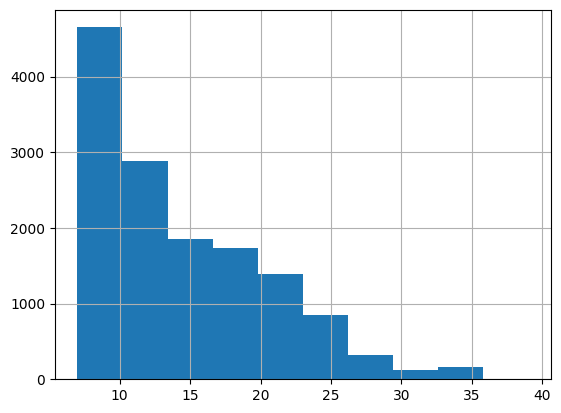

In [32]:
df['depression_risk'].hist()

In [33]:
df.drop(['n_85', 'n_86', 'n_87', 'n_88','n_90','n_91','n_92','n_93','var00001','univers0','region2','cluster2','cross2','sex2','birth_y0','sample_0'],axis=1,inplace=True)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['depression_risk']] = scaler.fit_transform(df[['depression_risk']])

In [35]:
df['depression_risk'].isna().sum()

0

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
X = df.drop(['depression_risk'],axis=1)
y = df['depression_risk']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)
scaler = MinMaxScaler()
# Fit and transform on training data, transform only on test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.06613214909384468, 0.8776854807571819)

In [37]:
X.columns

Index(['id2', 'University', 'region', 'cluster', 'cross', 'sex', 'birth_ye',
       'sample_c', 'a_1', 'a_2',
       ...
       'hp_97_2', 'hp_97_20', 'hp_98', 'parental', 'hp_100', 'hp_101',
       'hp_102', 'hp_103', 'hp_104', 'hp_105'],
      dtype='object', length=340)

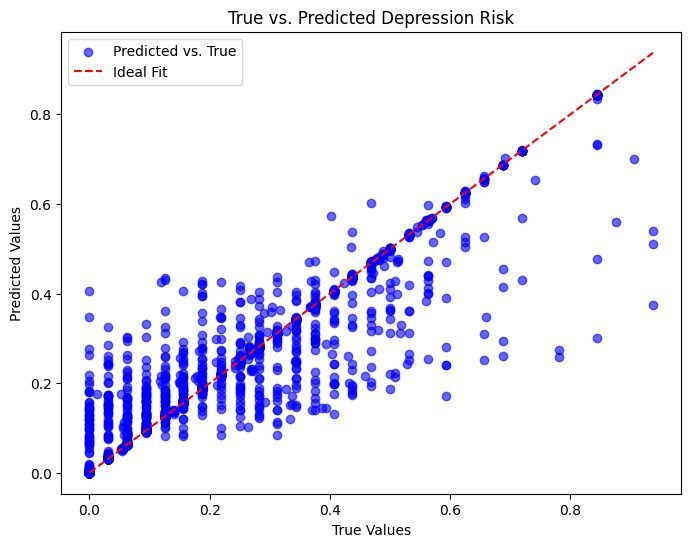

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='b', label='Predicted vs. True')

# Plot ideal line (y = x) for reference
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted Depression Risk")
plt.legend()
plt.show()


In [39]:
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)

100%|===================| 2784/2797 [02:06<00:00]        

In [40]:
feature_names = X.columns  # Get feature names from original DataFrame


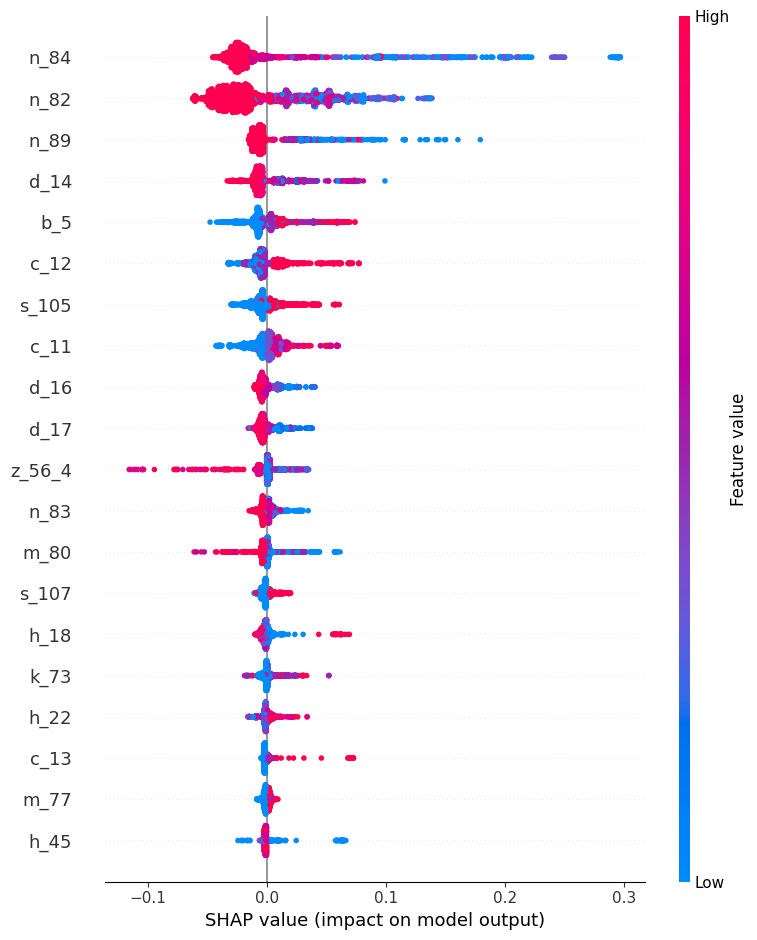

In [41]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

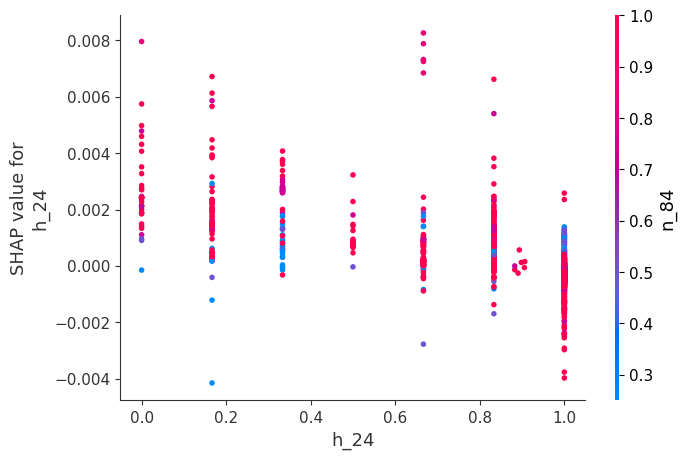

In [42]:
shap_values_array = shap_values.values  # Extract numeric SHAP values
shap.dependence_plot('h_24', shap_values_array, X_test_scaled, feature_names=feature_names)


In [43]:
df['h_24'].value_counts()

7.000000    9392
6.000000    3063
5.000000     556
2.000000     307
3.000000     283
4.000000     180
1.000000     174
6.296254       4
6.463345       4
6.467409       4
6.377143       4
6.360870       3
6.432945       3
6.389912       2
6.443389       1
6.438267       1
6.343356       1
6.358576       1
Name: h_24, dtype: int64